https://gitlab.com/ronctli1012/blog1-pretrained-alexnet-and-visualization/-/blob/master/alexnet_main.py?ref_type=heads

from cv2 import cv2 

# Imports

In [10]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as utils
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

# Get images and labels

In [11]:
# Define the transformations for data augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Rotate the image by up to 10 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Flip the image horizontally with a probability of 0.5
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Crop a random portion of the image and resize it to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [12]:
class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Traverse the root directory and collect paths of all image files
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                label_images = [f for f in os.listdir(label_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
                self.image_paths.extend([os.path.join(label_dir, img) for img in label_images])
                self.labels.extend([label] * len(label_images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Get the number of samples in the dataset
    total_samples = len(dataset)
    
    # Shuffle the indices
    indices = np.arange(total_samples)
    np.random.shuffle(indices)
    
    # Calculate the number of samples for each split
    train_size = int(train_ratio * total_samples)
    val_size = int(val_ratio * total_samples)
    test_size = total_samples - train_size - val_size
    
    # Split the indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]
    
    # Create SubsetRandomSampler instances
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    
    return train_sampler, val_sampler, test_sampler

In [13]:
# Define the total dataset
dataset = PlantDataset(root_dir='C:/Users/asche/OneDrive/Skrivebord/invasive_plant_classifier/Downloading_images/data'  , transform=train_transforms)

In [14]:
print(len(dataset))

200


# Make train val and test sets

- Training imagea are 80%
- Validation images are 20%
- Testing images are 20%.

In [15]:
# Define the sizes of subsets for training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

# Create subsets for training, validation, and test sets
train_subset_indices = torch.randperm(len(dataset))[:train_size]
val_subset_indices = torch.randperm(len(dataset))[train_size:train_size+val_size]
test_subset_indices = torch.randperm(len(dataset))[train_size+val_size:]

train_subset = Subset(dataset, train_subset_indices)
val_subset = Subset(dataset, val_subset_indices)
test_subset = Subset(dataset, test_subset_indices)

# Create DataLoader instances for subsets
batch_size = 1
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Print the lengths of DataLoader instances
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

160
20
20


### How many plant-images do we have from each class

In [16]:
# Initialize a dictionary to store the count of images for each plant
images_per_plant = {}

# Iterate through subfolders (plants) in the root directory
root_dir = 'C:/Users/asche/OneDrive/Skrivebord/invasive_plant_classifier/Downloading_images/data'  
for plant_folder in os.listdir(root_dir):
    # Construct the full path to the plant folder
    plant_folder_path = os.path.join(root_dir, plant_folder)
    
    # Check if it's a directory
    if os.path.isdir(plant_folder_path):
        # Count the number of images in the folder
        images_count = len(os.listdir(plant_folder_path))
        
        # Store the count in the dictionary with the plant name as the key
        images_per_plant[plant_folder] = images_count

# Print the count of images for each plant
for plant, count in images_per_plant.items():
    print(f'Number of images for {plant}: {count}')


Number of images for Cardiospermum grandiflorum: 100
Number of images for Cortaderia jubata: 100


# Setup classifier

In [17]:
# great paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8747718/ 

## Find labels

In [18]:
unique_labels = set()

# Iterate over the training dataset
for _, label in train_dataloader:
    unique_labels.add(label[0])  # Extract the label string from the tuple

# Iterate over the validation dataset
for _, label in val_dataloader:
    unique_labels.add(label[0])  # Extract the label string from the tuple

# Iterate over the test dataset
for _, label in test_dataloader:
    unique_labels.add(label[0])  # Extract the label string from the tuple

# Calculate the number of unique classes
num_classes = len(unique_labels)

# Print the unique plant names
print("Unique Plant Names:", unique_labels)
print("Number of Unique Classes:", num_classes)


Unique Plant Names: {'Cortaderia jubata', 'Cardiospermum grandiflorum'}
Number of Unique Classes: 2


## Setup the model architecture

In [19]:
class PlantClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PlantClassifier, self).__init__()
        # Define convolutional blocks
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Define fully connected layers
        self.fc = nn.Linear(64 * 28 * 28, num_classes)  # Adjust input size based on final feature map size

    def forward(self, x):
        # Forward pass through convolutional blocks
        x = self.conv_block(x)
        # Flatten the output for fully connected layer
        x = x.view(-1, 64 * 28 * 28)  # Adjust based on final feature map size
        # Pass through fully connected layer
        out = self.fc(x)
        return out

# Load pre-trained VGG16 model
vgg16 = models.vgg16()

# Modify the fully connected layer for plant classification
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)

# Optionally freeze pre-trained layers
# for param in vgg16.features.parameters():
#     param.requires_grad = False

# Define your own classifier and its optimizer and loss function
model = PlantClassifier(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Combine VGG16 convolutional base with your custom classifier
class CombinedModel(nn.Module):
    def __init__(self, vgg, custom_classifier):
        super(CombinedModel, self).__init__()
        self.vgg = vgg.features  # Only taking the convolutional layers
        self.custom_classifier = custom_classifier

    def forward(self, x):
        x = self.vgg(x)
        x = x.view(x.size(0), -1)
        x = self.custom_classifier(x)
        return x

# Instantiate the combined model
combined_model = CombinedModel(vgg16, model)

# Define optimizer and loss function for the combined model
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Architecture:
- The convolutional blocks consist of three convolutional layers, 
each followed by a ReLU activation and a max pooling layer. 
- This helps in extracting hierarchical features from the input images.
-The output feature maps are downsampled through max pooling layers, 
ensuring consistent output shapes regardless of the input size.
- The fully connected layer's input size is adjusted based on the final 
feature map size after downsampling.

# Run the training loop

In [24]:
# Define the number of epochs and early stopping parameters
num_epochs = 25
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    # Create a mapping from unique labels to numerical indices
    label_to_index = {label: index for index, label in enumerate(unique_labels)}

    # Training loop
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        
        # Extract the string label from the tuple and convert to numerical index
        label_index = label_to_index[labels[0]]
        
        # Convert numerical index to tensor
        labels = torch.tensor([label_index], dtype=torch.long)  # Ensure the labels tensor has batch size 1
        
        loss = F.cross_entropy(outputs, labels)
        train_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

        loss.backward()
        optimizer.step()


    # Calculate average training loss and accuracy
    train_loss /= len(train_dataloader)
    train_accuracy = correct_train_predictions / total_train_predictions

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    label_to_index = {label: index for index, label in enumerate(unique_labels)}

    with torch.no_grad():
        for images, labels_tuple in val_dataloader:  # Unpack the labels tuple
            outputs = model(images)
            
            # Extract the label from the tuple
            labels = labels_tuple[0]  # Assuming the label is the first element in the tuple
            
            # Convert the label to its corresponding index
            label_index = label_to_index[labels]
            
            # Convert label index to tensor
            labels = torch.tensor([label_index], dtype=torch.long)
            
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.size(0)


    # Calculate average validation loss and accuracy
    val_loss /= len(val_dataloader)
    val_accuracy = correct_val_predictions / total_val_predictions

    # Save training and validation losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check for early stopping based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Print training and validation loss and accuracy
    print(f'Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
    f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 0, Training Loss: 0.4858, Validation Loss: 0.4750, Training Accuracy: 0.8125, Validation Accuracy: 0.7500
Epoch 1, Training Loss: 0.4224, Validation Loss: 0.7134, Training Accuracy: 0.8438, Validation Accuracy: 0.7500
Epoch 2, Training Loss: 0.4481, Validation Loss: 0.4487, Training Accuracy: 0.8500, Validation Accuracy: 0.8500
Epoch 3, Training Loss: 0.2904, Validation Loss: 0.8204, Training Accuracy: 0.8750, Validation Accuracy: 0.6500
Epoch 4, Training Loss: 0.4007, Validation Loss: 0.2760, Training Accuracy: 0.8750, Validation Accuracy: 0.9000
Epoch 5, Training Loss: 0.2534, Validation Loss: 0.6742, Training Accuracy: 0.8938, Validation Accuracy: 0.7000
Epoch 6, Training Loss: 0.3854, Validation Loss: 0.4025, Training Accuracy: 0.8688, Validation Accuracy: 0.9000
Early stopping at epoch 7


## Loss curve & accuracy curve

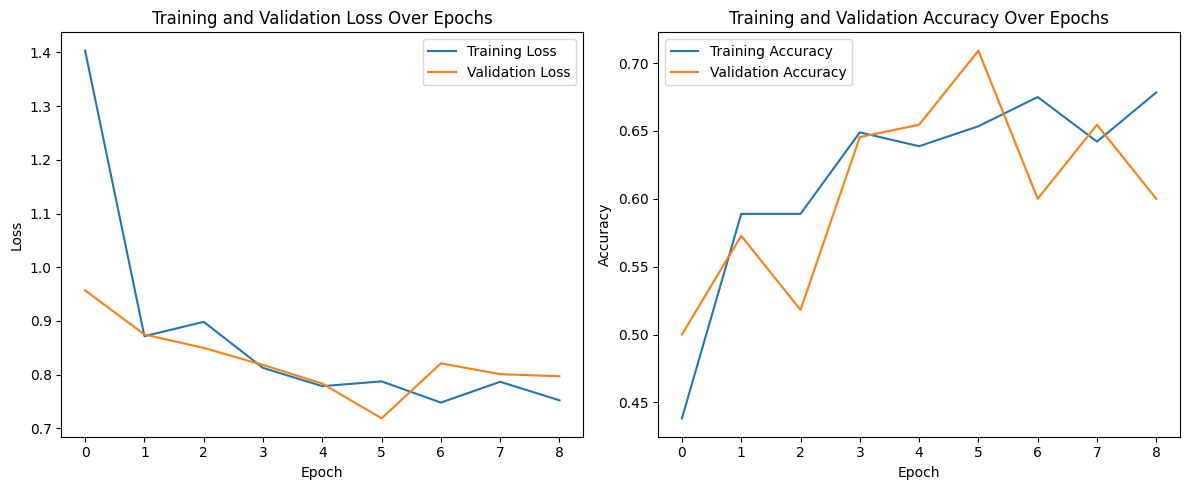

In [ ]:
# Plotting training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Testing

In [ ]:
# Testing phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_dataloader:  # Assuming you have a separate test dataloader
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the index of the maximum output
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate average test loss
test_loss /= len(test_dataloader)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Print test loss and accuracy
print(f'Test Loss: {test_loss}, Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.8437811434268951, Accuracy: 60.36%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


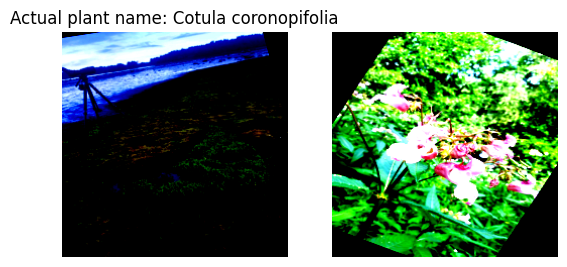

Predicted Label: Impatiens glandulifera


In [ ]:
# Normalize the images for visualization
def denormalize(image, mean, std):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# Extract a single batch from the test dataloader
for images, labels in test_dataloader:
    # Take the first image and its corresponding label
    image = images[0]
    actual_label_idx = labels[0]

    # Convert numerical label index to the corresponding plant name
    actual_label = dataset.idx_to_label[actual_label_idx.item()]

    # Get the model's prediction
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add an extra dimension to simulate batch size of 1
        _, predicted = torch.max(output, 1)
        predicted_label_idx = predicted.item()

    # Convert numerical predicted label index to the corresponding plant name
    predicted_label = dataset.idx_to_label[predicted_label_idx]

    # If the predicted label is different from the actual label
    if actual_label != predicted_label:
        # Get an image from the test dataset that belongs to the predicted label
        predicted_label_images = [img for img, lbl in test_dataset if lbl == predicted_label_idx]
        predicted_image = predicted_label_images[0]  # Take the first image for simplicity

        # Denormalize and visualize the actual image
        plt.subplot(1, 2, 1)
        plt.imshow(denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        plt.title(f'Actual plant name: {actual_label}')
        plt.axis('off')

        # Denormalize and visualize the predicted image
        plt.subplot(1, 2, 2)
        plt.imshow(denormalize(predicted_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        plt.axis('off')
        plt.show()
        break

print(f'Predicted Label: {predicted_label}')

# Confusion matrix

<Figure size 800x600 with 0 Axes>

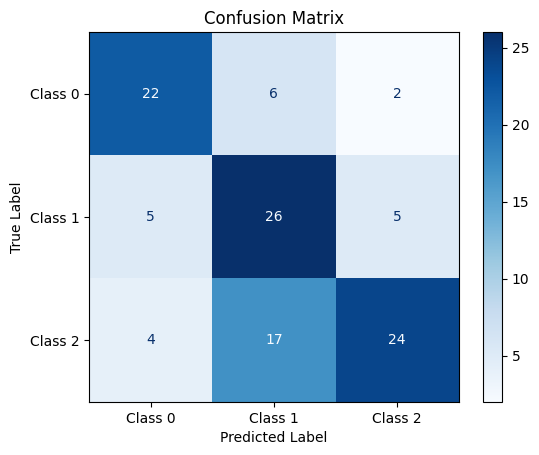

In [ ]:
model.eval()
predicted_labels = []
true_labels = []

# Iterate through the test dataset to get predicted and true labels
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
classes = [f"Class {i}" for i in range(len(cm))]  # Assuming classes are labeled as 0, 1, 2, ..., num_classes-1
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')  # 'd' for integer formatting
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
''' a test
# Define the arguments
class Args:
    def __init__(self):
        self.test_img = 'C:/Users/asche/plants/data/train/images/aesculus californica (spach) nutt/131728.jpg'

# Instantiate the args
opt = Args()

"""
data transforms, for pre-processing the input testing image before feeding into the net
"""
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),             # resize the input to 224x224
    transforms.ToTensor(),              # put the input to tensor format
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize the input
    # the normalization is based on images from ImageNet
])

# obtain the file path of the testing image
test_image_dir = './alexnet_images'
test_image_filepath = os.path.join(test_image_dir, opt.test_img)
#print(test_image_filepath)

# open the testing image
img = Image.open(test_image_filepath)
print("original image's shape: " + str(img.size))

# pre-process the input
transformed_img = data_transforms(img)
print("transformed image's shape: " + str(transformed_img.shape))

'''

' a test\n# Define the arguments\nclass Args:\n    def __init__(self):\n        self.test_img = \'C:/Users/asche/plants/data/train/images/aesculus californica (spach) nutt/131728.jpg\'\n\n# Instantiate the args\nopt = Args()\n\n"""\ndata transforms, for pre-processing the input testing image before feeding into the net\n"""\ndata_transforms = transforms.Compose([\n    transforms.Resize((224,224)),             # resize the input to 224x224\n    transforms.ToTensor(),              # put the input to tensor format\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize the input\n    # the normalization is based on images from ImageNet\n])\n\n# obtain the file path of the testing image\ntest_image_dir = \'./alexnet_images\'\ntest_image_filepath = os.path.join(test_image_dir, opt.test_img)\n#print(test_image_filepath)\n\n# open the testing image\nimg = Image.open(test_image_filepath)\nprint("original image\'s shape: " + str(img.size))\n\n# pre-process the input